# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Muhammad Teguh Alfian]
- **Email:** [teguhalfian01.mta@gmail.com]
- **ID Dicoding:** [Muhammad Teguh Alfian]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d 'hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images'

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
 96% 45.0M/47.0M [00:03<00:00, 23.8MB/s]
100% 47.0M/47.0M [00:03<00:00, 15.1MB/s]


In [4]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d ./Data

Streaming output truncated to the last 5000 lines.
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: ./Data/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009)

In [5]:
print(os.listdir('./Data'))
print(os.listdir('./Data/Shoe vs Sandal vs Boot Dataset'))

['Shoe vs Sandal vs Boot Dataset']
['Boot', 'Shoe', 'Sandal']


### Data Preprocessing

In [6]:
import os
import shutil
import random

# Path asal (folder hasil unzip)
original_dataset_dir = './Data/Shoe vs Sandal vs Boot Dataset'   # misal folder ini berisi semua gambar campur

# Path tujuan
base_dir = './Data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Buat folder train, val, test
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

classes = ['Boot', 'Sandal', 'Shoe']

# Untuk setiap kelas
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Ambil semua file dari kelas itu
    cls_folder = os.path.join(original_dataset_dir, cls)
    images = os.listdir(cls_folder)
    random.shuffle(images)  # Acak dulu

    # Split: 80% train, 10% val, 10% test
    n_total = len(images)
    n_train = int(0.8 * n_total)
    n_val = int(0.10 * n_total)

    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]

    # Copy file ke masing-masing folder
    for img in train_images:
        src = os.path.join(cls_folder, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)

    for img in val_images:
        src = os.path.join(cls_folder, img)
        dst = os.path.join(val_dir, cls, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(cls_folder, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

print('Data sudah dibagi menjadi train, validation, dan test!')


Data sudah dibagi menjadi train, validation, dan test!


#### Split Dataset

## Modelling

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalisasi pixel (0-255 jadi 0-1)
    rotation_range=40,             # Rotasi gambar hingga 40 derajat
    width_shift_range=0.2,         # Geser gambar secara horizontal hingga 20%
    height_shift_range=0.2,        # Geser gambar secara vertikal hingga 20%
    shear_range=0.2,               # Shear (melengkungkan gambar)
    zoom_range=0.2,                # Zoom-in/Zoom-out hingga 20%
    horizontal_flip=True,          # Membalik gambar secara horizontal
    fill_mode='nearest'            # Cara mengisi pixel baru setelah augmentasi
)

# Untuk validasi/test data, biasanya hanya rescale tanpa augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Load gambar dari folder
train_generator = train_datagen.flow_from_directory(
    './Data/train',
    target_size=(150, 150),         # Ukuran gambar yang di-resize
    batch_size=45,
    class_mode='categorical'        # Karena multiclass (boot, sandal, shoe)
)

validation_generator = val_datagen.flow_from_directory(
    './Data/val',
    target_size=(150, 150),
    batch_size=15,
    class_mode='categorical'
)


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [8]:
from tensorflow.keras import layers, models, Input

# Membuat model Sequential
model = models.Sequential([
    Input(shape=(150, 150, 3)),  # Gunakan Input sebagai layer pertama
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax') # gunakan softmax karena ada 3 kelas
])

# Melihat ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile model
model.compile(
    loss='categorical_crossentropy',   # multiclass classification
    optimizer='adam',
    metrics=['accuracy']
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[earlystop, checkpoint]
)


Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6045 - loss: 0.9868

267/267 ━━━━━━━━━━━━━━━━━━━━ 72s 261ms/step - accuracy: 0.6047 - loss: 0.9861 - val_accuracy: 0.7593 - val_loss: 0.5430
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7334 - loss: 0.6336

267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 251ms/step - accuracy: 0.7335 - loss: 0.6335 - val_accuracy: 0.8107 - val_loss: 0.4286
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 252ms/step - accuracy: 0.7949 - loss: 0.4971 - val_accuracy: 0.8280 - val_loss: 0.4321
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8329 - loss: 0.4201

267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 250ms/step - accuracy: 0.8329 - loss: 0.4201 - val_accuracy: 0.9007 - val_loss: 0.2485
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - accuracy: 0.8552 - loss: 0.3680 - val_accuracy: 0.8920 - val_loss: 0.2659
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8735 - loss: 0.3201

267/267 ━━━━━━━━━━━━━━━━━━━━ 68s 255ms/step - accuracy: 0.8735 - loss: 0.3201 - val_accuracy: 0.9193 - val_loss: 0.2313
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8874 - loss: 0.2888

267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 252ms/step - accuracy: 0.8874 - loss: 0.2889 - val_accuracy: 0.9260 - val_loss: 0.2110
Epoch 8/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9029 - loss: 0.2550

267/267 ━━━━━━━━━━━━━━━━━━━━ 68s 253ms/step - accuracy: 0.9029 - loss: 0.2550 - val_accuracy: 0.9387 - val_loss: 0.1874
Epoch 9/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.9032 - loss: 0.2580 - val_accuracy: 0.9213 - val_loss: 0.1961
Epoch 10/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9132 - loss: 0.2307

267/267 ━━━━━━━━━━━━━━━━━━━━ 68s 253ms/step - accuracy: 0.9132 - loss: 0.2307 - val_accuracy: 0.9400 - val_loss: 0.1610
Epoch 11/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9124 - loss: 0.2320

267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 251ms/step - accuracy: 0.9124 - loss: 0.2320 - val_accuracy: 0.9413 - val_loss: 0.1593
Epoch 12/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9206 - loss: 0.2190

267/267 ━━━━━━━━━━━━━━━━━━━━ 68s 253ms/step - accuracy: 0.9207 - loss: 0.2190 - val_accuracy: 0.9520 - val_loss: 0.1385
Epoch 13/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 66s 247ms/step - accuracy: 0.9176 - loss: 0.2105 - val_accuracy: 0.9320 - val_loss: 0.1740
Epoch 14/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9127 - loss: 0.2350

267/267 ━━━━━━━━━━━━━━━━━━━━ 68s 253ms/step - accuracy: 0.9128 - loss: 0.2350 - val_accuracy: 0.9473 - val_loss: 0.1341
Epoch 15/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 66s 247ms/step - accuracy: 0.9245 - loss: 0.1962 - val_accuracy: 0.9380 - val_loss: 0.1650
Epoch 16/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 249ms/step - accuracy: 0.9294 - loss: 0.1875 - val_accuracy: 0.9500 - val_loss: 0.1350
Epoch 17/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.9358 - loss: 0.1787 - val_accuracy: 0.9420 - val_loss: 0.1501
Epoch 18/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.9378 - loss: 0.1691 - val_accuracy: 0.9480 - val_loss: 0.1419
Epoch 19/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.9361 - loss: 0.1711 - val_accuracy: 0.9560 - val_loss: 0.1383


## Evaluasi dan Visualisasi

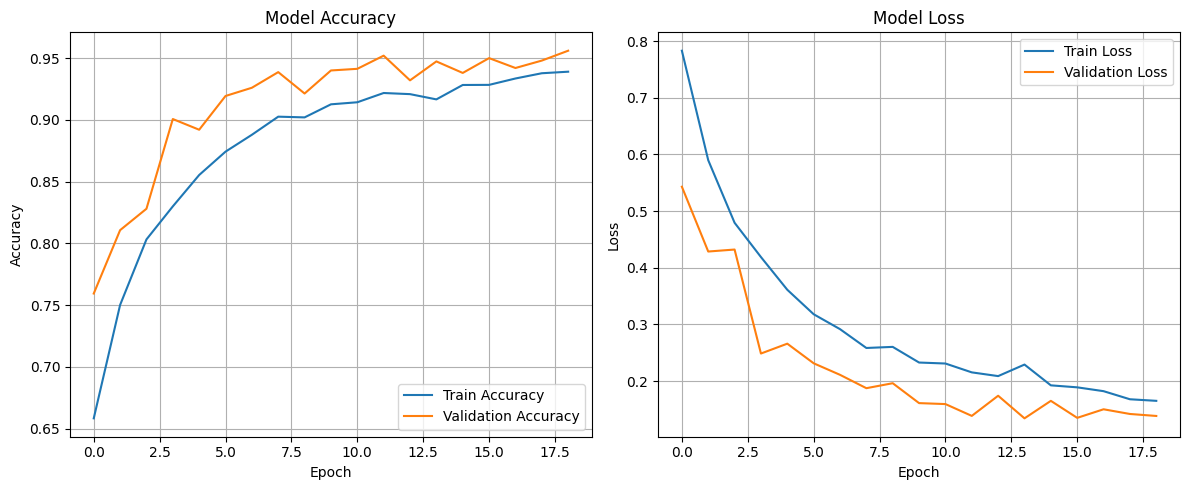

In [13]:
import matplotlib.pyplot as plt

# Visualisasi Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Visualisasi Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Found 1500 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


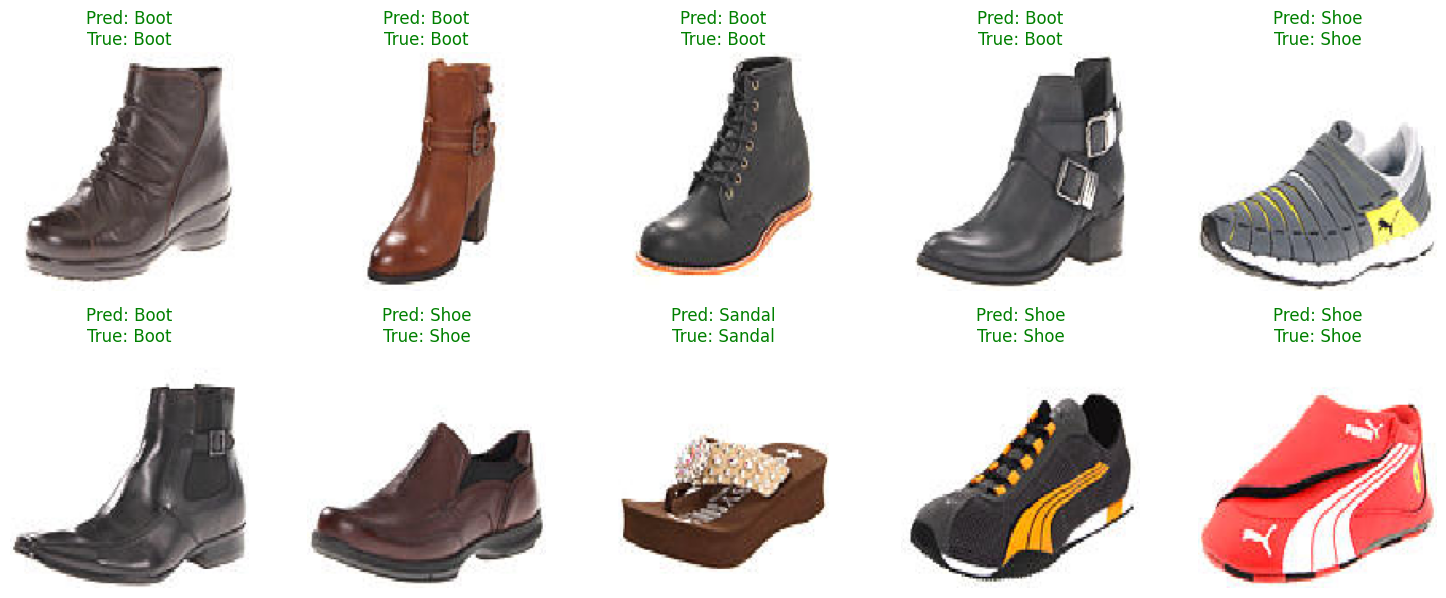

In [15]:
# Load test data generator
test_generator = val_datagen.flow_from_directory(
    './Data/test',
    target_size=(150, 150),
    batch_size=1,             # Satu gambar per batch
    class_mode='categorical',
    shuffle=True
)

# Ambil label kelas
class_names = list(test_generator.class_indices.keys())

# Prediksi beberapa gambar
num_images = 10   # jumlah gambar yang mau ditampilkan
plt.figure(figsize=(15, 15))

for i in range(num_images):
    img, label = next(test_generator)         # ambil satu batch (1 gambar)
    prediction = model.predict(img)            # prediksi gambar
    predicted_class = class_names[np.argmax(prediction)]  # ambil nama kelas prediksi
    true_class = class_names[np.argmax(label)]             # ambil nama kelas sebenarnya

    plt.subplot(5, 5, i + 1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(f"Pred: {predicted_class}\nTrue: {true_class}",
              color='green' if predicted_class == true_class else 'red')

plt.tight_layout()
plt.show()


In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9568 - loss: 0.1054
Test Accuracy: 0.95


## Konversi Model

In [18]:
import tensorflow as tf

# Simpan model dalam format SavedModel
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)

# Konversi ke format .pb
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Simpan model .pb
with open('model.pb', 'wb') as f:
  f.write(tflite_model)

print("Model berhasil diekspor ke format .pb dan variables")

Model berhasil diekspor ke format .pb dan variables


In [21]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('best_model.h5')

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights as a .h5 file
model.save_weights('model.weights.h5')

print("Model architecture saved to model.json")
print("Model weights saved to model.weights.h5")

Model architecture saved to model.json
Model weights saved to model.weights.h5


In [22]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


Saved artifact at '/tmp/tmpav1e74ym'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132371968173136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968175248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968170064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968168720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968171408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968172752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968173520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968172368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968173904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371968177168: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [23]:
!pip freeze > requirements.txt

## Inference (Optional)